# Lab 3 for STAT 415
## Xiaolong Liu
## Apr. 2024

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sentence_transformers import SentenceTransformer
import re

In [8]:
restaurants = pd.read_excel('Datasets/Evanston Restaurant Reviews.xlsx', sheet_name='Restaurants')
reviews = pd.read_excel('Datasets/Evanston Restaurant Reviews.xlsx', sheet_name='Reviews')

restaurants['Restaurant Name'] = restaurants['Restaurant Name'].str.strip()
reviews['Restaurant Name'] = reviews['Restaurant Name'].str.strip()

In [9]:
def correct_and_convert_dates(entry):
    # Check if the entry is a string, which might indicate a typo that needs correction
    if isinstance(entry, str):
        # Correct common date typos, such as '5-0-2022'
        pattern = r'(\d{1,2})-0-(\d{4})'
        replacement = r'\1-01-\2'  # Assumes January as the default month
        corrected_date = re.sub(pattern, replacement, entry)
        try:
            # Try converting the corrected string to datetime
            return pd.to_datetime(corrected_date, errors='coerce')
        except ValueError:
            # In case of other unrecognized formats, return NaT
            return pd.NaT
    else:
        # If it's already a datetime type or similar, return as is
        return entry

In [10]:
reviews['Date of Review'] = reviews['Date of Review'].apply(correct_and_convert_dates)

In [11]:
# Convert all entries in 'Marital Status' to lower case to handle case sensitivity
reviews['Marital Status'] = reviews['Marital Status'].str.lower()

# Replace values to unify similar terms
replacement_map = {
    'widow': 'widowed',  # Replace 'widow' with 'widowed'
    'single': 'single',  # Ensure 'single' is uniformly used
    'single ': 'single'
}

# Apply the replacement map
reviews['Marital Status'] = reviews['Marital Status'].replace(replacement_map)

# Optionally, correct any remaining case issues by capitalizing the first letter (if needed)
reviews['Marital Status'] = reviews['Marital Status'].str.capitalize()

# Check the unique values after modification
print(reviews['Marital Status'].unique())

['Single' 'Married' 'Widowed' nan]


In [12]:
reviews_sorted = reviews.sort_values(by=['Reviewer Name', 'Date of Review'], ascending=[True, False])

# Drop duplicates, keeping only the first entry for each user-restaurant pair (which is the latest due to sorting)
reviews = reviews_sorted.drop_duplicates(subset=['Reviewer Name', 'Restaurant Name'])

In [13]:
categorical_columns = ['Marital Status', 'Has Children?', 'Vegetarian?', 'Average Amount Spent', 
                       'Preferred Mode of Transport', 'Northwestern Student?']

for column in categorical_columns:
    reviews[column].fillna('Missing', inplace=True)

/var/folders/67/kpl0tnjd1md6qddgggbqjqyr0000gn/T/ipykernel_20475/951469188.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews[column].fillna('Missing', inplace=True)


In [14]:
reviews = reviews.reset_index()

# Collaborative Filtering

### 1) Use the demographic data in 'Reviews.csv' to create a unique user feature vector for each reviewer, including numeric representations of all demographic attributes in the data, including but not limited to 'Has Children?', 'Weight (lb)', 'Preferred Mode of Transport', etc. Apply one-hot encoding for categorical variables. Ensure each vector is unique to an individual reviewer, by avoiding double counting. Many reviewers have submitted reviews for multiple restaurants, so you do not want to count these people twice when making these vectors. Report the total number of unique user vectors created and the dimensionality of each vector.

### Another way of asking this question: Create a user feature matrix where row $i$ is a unique user and column $j$ is that user's feature vector.

In [15]:
reviews.head()

,index,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
0,6,A B,Graduate Homestead Room,2,"Good service, beautiful interior but the food,...",2023-01-11,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No
1,8,A B,Panino's Pizzeria,2,NaN,2023-01-03,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No
2,4,A B,Edzo's Burger Shop,5,Second best burger in Evanston,2022-11-28,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No
3,1,A B,Barn Steakhouse,5,Excellent meal in a warm atmosphere! The space...,2022-11-22,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No
4,3,A B,Clarkes Off Campus,5,Best burger in Evanston,2022-10-30,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No


In [16]:
unique_users_df = reviews.drop_duplicates(subset='Reviewer Name', keep='first')
demographic = ['Reviewer Name', 'Birth Year', 'Marital Status', 'Has Children?', 'Vegetarian?', 'Weight (lb)', 'Height (in)', 
               'Average Amount Spent', 'Preferred Mode of Transport', 'Northwestern Student?']
unique_users_df = unique_users_df[demographic].reset_index()

In [17]:
reviews_categorical = unique_users_df[categorical_columns]

encoder = OneHotEncoder(sparse=False)
reviews_encoded = encoder.fit_transform(reviews_categorical)
reviews_encoded = pd.DataFrame(reviews_encoded, columns=encoder.get_feature_names_out(categorical_columns))

/Users/always/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
unique_users_df = pd.concat([unique_users_df, reviews_encoded], axis=1)
unique_users_df = unique_users_df.drop(categorical_columns, axis=1)
unique_users_df.index = unique_users_df['Reviewer Name']
unique_users_df = unique_users_df.drop('Reviewer Name', axis=1)

for column in ['Birth Year', 'Weight (lb)', 'Height (in)']:
    unique_users_df[column].fillna(unique_users_df[column].mean(), inplace=True)

scaler = StandardScaler()

unique_users_df[['Birth Year', 'Weight (lb)', 'Height (in)']] = scaler.fit_transform(unique_users_df[['Birth Year', 'Weight (lb)', 'Height (in)']])
unique_users_df.head()

,index,Birth Year,Weight (lb),Height (in),Marital Status_Married,Marital Status_Missing,Marital Status_Single,Marital Status_Widowed,Has Children?_Missing,Has Children?_No,...,Average Amount Spent_High,Average Amount Spent_Low,Average Amount Spent_Medium,Average Amount Spent_Missing,Preferred Mode of Transport_Car Owner,Preferred Mode of Transport_Missing,Preferred Mode of Transport_On Foot,Preferred Mode of Transport_Public Transit,Northwestern Student?_No,Northwestern Student?_Yes
Reviewer Name,,,,,,,,,,,,,,,,,,,,,
A B,0,1.105963,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Abigail,9,1.260878,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Actual P.,11,0.899409,0.691541,-7.528738e-01,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Adam Gibbons,12,1.157601,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Agnes Zuber,13,-0.081720,-1.293166,-1.235723e+00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [19]:
unique_users_df = unique_users_df.drop(['index'], axis = 1)
unique_users_df 

,Birth Year,Weight (lb),Height (in),Marital Status_Married,Marital Status_Missing,Marital Status_Single,Marital Status_Widowed,Has Children?_Missing,Has Children?_No,Has Children?_Yes,...,Average Amount Spent_High,Average Amount Spent_Low,Average Amount Spent_Medium,Average Amount Spent_Missing,Preferred Mode of Transport_Car Owner,Preferred Mode of Transport_Missing,Preferred Mode of Transport_On Foot,Preferred Mode of Transport_Public Transit,Northwestern Student?_No,Northwestern Student?_Yes
Reviewer Name,,,,,,,,,,,,,,,,,,,,,
A B,1.105963,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Abigail,1.260878,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Actual P.,0.899409,0.691541,-7.528738e-01,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Adam Gibbons,1.157601,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Agnes Zuber,-0.081720,-1.293166,-1.235723e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yoshie Hubbell,-1.372681,-0.686727,-1.304702e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Yujia Ji,-0.339912,-0.282435,-1.960488e-15,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Zach,1.209240,-1.017512,-1.097766e+00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### 2) Using the vectors created in the previous question, write a function that computes the distance from one user to all others. With this function, build a recommendation algorithm that takes a user and outputs a recommendation made by the most similar user (i.e. the most similar users favorite restaurant). Demonstrate this algorithm by selecting 'Timothy Mace' as your user, and in your report, include his most similar user and the recommendations provided. Based on this example, explain how this algorithm works. Does this algorithm always suggest more than one recommendation for every user in the dataset? If not, propose a possible solution.

In [20]:
def find_closest_user_with_pdist(df, user_name):
    # Check if user_name exists in the DataFrame
    if user_name not in df.index:
        return "User not found in the DataFrame."

    # Compute the pairwise cosine distances between all users
    distance_matrix = squareform(pdist(df.values, metric='cosine'))

    # Get the index of the user
    user_index = df.index.get_loc(user_name)

    # Set the distance with the user itself to a high value to ignore it
    distance_matrix[user_index, user_index] = np.inf

    # Find the index of the closest user
    closest_user_idx = np.argmin(distance_matrix[user_index])

    # Return the name of the closest user
    return df.index[closest_user_idx]

In [21]:
close_user = find_closest_user_with_pdist(unique_users_df, 'Timothy Mace')
close_user

'L S'

In [22]:
review_user = reviews[reviews['Reviewer Name'] == close_user]
restaurant_name = review_user[review_user['Rating'] == review_user['Rating'].max()]['Restaurant Name']
restaurant_name

792    Cross Rhodes
Name: Restaurant Name, dtype: object

### 3) Rather than finding users that are similar in terms of demographics, we want to find users that gave similar reviews. To find users that have given similar reviews, for each user $j$ you will want to form a 63-dimensional vector where entry $i$ is the user $j$'s review of restaurant $i$. This vector will have many blank entries. What should you use to fill in these blanks? Hint: probably not 0.

### Note, another way of forming question 3 is this: Make a matrix where $a_{ij}$ is user $j$'s review of restaurant $i$. Fill in the blank entries of this matrix.

In [23]:
reviews.head()

,index,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
0,6,A B,Graduate Homestead Room,2,"Good service, beautiful interior but the food,...",2023-01-11,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No
1,8,A B,Panino's Pizzeria,2,NaN,2023-01-03,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No
2,4,A B,Edzo's Burger Shop,5,Second best burger in Evanston,2022-11-28,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No
3,1,A B,Barn Steakhouse,5,Excellent meal in a warm atmosphere! The space...,2022-11-22,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No
4,3,A B,Clarkes Off Campus,5,Best burger in Evanston,2022-10-30,1998.0,Single,No,Missing,NaN,NaN,Medium,On Foot,No


In [24]:
rating_matrix = reviews.pivot_table(index='Reviewer Name', columns='Restaurant Name', values='Rating')
rating_matrix

Restaurant Name,5411 Empanadas,Alcove,Barn Steakhouse,Brothers K Coffeehouse,Burger King,Campagnola,Celtic Knot Public House,Chipotle,Claire's Korner,Clare's Korner,...,Tapas Barcelona,Taste of Nepal,Tealicious,Todoroki Sushi,Tomo Japanese Street Food,Trattoria DOC,Trattoria Demi,Union Pizzeria,World Market,Zentli
Reviewer Name,,,,,,,,,,,,,,,,,,,,,
A B,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abigail,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actual P.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adam Gibbons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Agnes Zuber,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yoshie Hubbell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yujia Ji,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
imputer = SimpleImputer(strategy='mean')
rating_matrix_filled_temp = pd.DataFrame(imputer.fit_transform(rating_matrix), index=rating_matrix.index, columns=rating_matrix.columns)

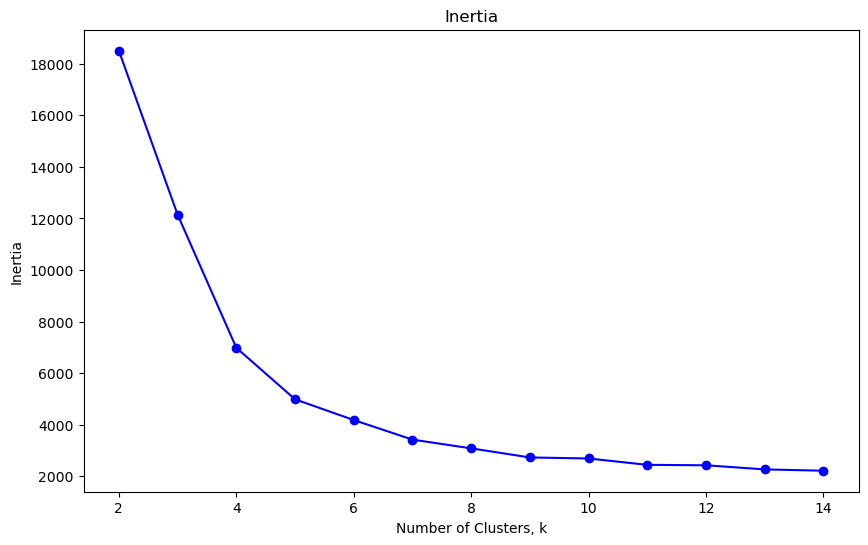

In [26]:
inertias = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(rating_matrix_filled_temp.T)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), inertias, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('Inertia')
plt.savefig('Image_Lab_3/inertia_kmeans.jpg', bbox_inches='tight')
plt.show()

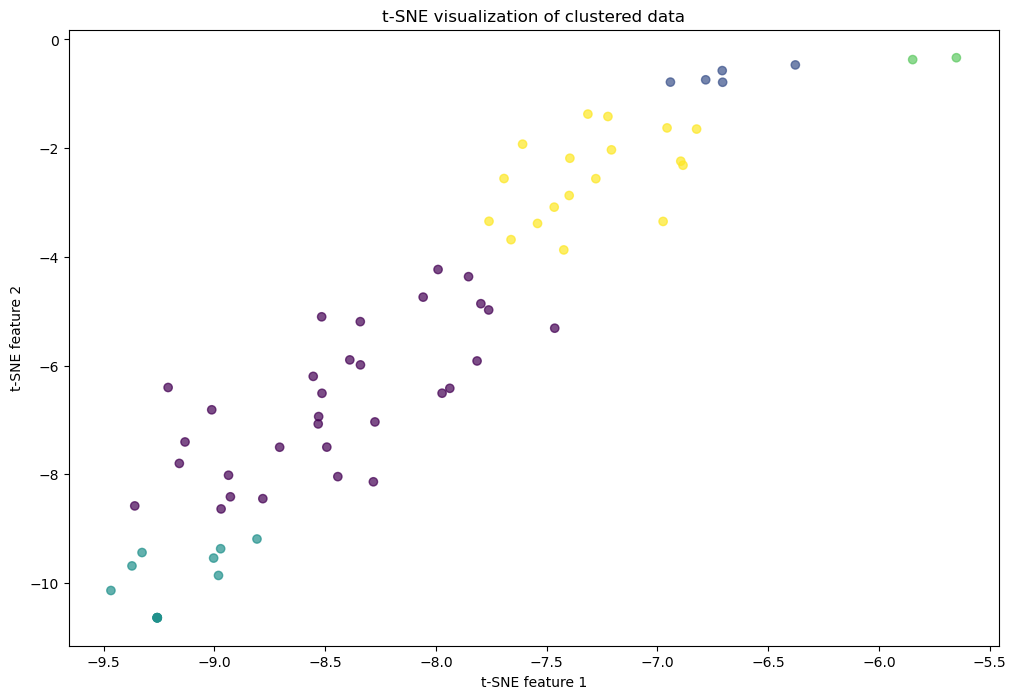

In [27]:
kmeans = KMeans(n_clusters=5, n_init='auto')  # Replace with the optimal number of clusters you've determined
clusters = kmeans.fit_predict(rating_matrix_filled_temp.T)

tsne = TSNE(n_components=2, random_state=10)
data_tsne = tsne.fit_transform(rating_matrix_filled_temp.T)

# Creating a scatter plot of the t-SNE reduced data
plt.figure(figsize=(12, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.7)

plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of clustered data')

plt.savefig('Image_Lab_3/tsne_kmeans.jpg', bbox_inches='tight')
plt.show()

In [28]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init='auto')
clusters = kmeans.fit_predict(rating_matrix_filled_temp.T)  # Transpose to cluster items, not users

# Map clusters to their mean ratings
cluster_means = {}
for cluster in np.unique(clusters):
    cluster_restaurants = rating_matrix_filled_temp.columns[clusters == cluster]
    cluster_mean = rating_matrix_filled_temp[cluster_restaurants].mean(axis=1).mean()
    cluster_means[cluster] = cluster_mean

def fill_with_cluster_means(col):
    # Finding the cluster of the current column
    cluster = clusters[col.name == rating_matrix.columns]
    # Returning the column with NaN filled with the mean of the cluster it belongs to
    return col.fillna(cluster_means[cluster[0]])

# Applying the function to each column in the original rating matrix
rating_matrix_imputed = rating_matrix.apply(fill_with_cluster_means)

rating_matrix_imputed

Restaurant Name,5411 Empanadas,Alcove,Barn Steakhouse,Brothers K Coffeehouse,Burger King,Campagnola,Celtic Knot Public House,Chipotle,Claire's Korner,Clare's Korner,...,Tapas Barcelona,Taste of Nepal,Tealicious,Todoroki Sushi,Tomo Japanese Street Food,Trattoria DOC,Trattoria Demi,Union Pizzeria,World Market,Zentli
Reviewer Name,,,,,,,,,,,,,,,,,,,,,
A B,3.469526,3.469526,5.000000,4.000000,1.4,3.994432,3.994432,2.870119,3.994432,1.4,...,3.994432,4.446783,4.446783,3.469526,3.994432,3.469526,3.469526,3.994432,4.960784,4.960784
Abigail,3.469526,3.469526,3.994432,5.000000,1.4,3.994432,3.994432,2.870119,3.994432,1.4,...,3.994432,4.446783,4.446783,3.469526,3.994432,3.469526,3.469526,3.994432,4.960784,4.960784
Actual P.,3.469526,3.469526,3.994432,4.446783,1.4,3.994432,3.994432,2.870119,3.994432,1.4,...,3.994432,4.446783,4.446783,3.469526,3.994432,3.469526,3.469526,3.994432,4.960784,4.960784
Adam Gibbons,3.469526,3.469526,3.994432,4.446783,1.4,3.994432,3.994432,2.870119,3.994432,1.4,...,3.994432,4.446783,4.446783,3.469526,3.994432,3.469526,3.469526,3.994432,4.960784,4.960784
Agnes Zuber,3.469526,3.469526,3.994432,4.446783,1.4,3.994432,3.994432,2.870119,3.994432,1.4,...,3.994432,4.446783,4.446783,3.469526,3.994432,3.469526,3.469526,3.994432,4.960784,4.960784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yoshie Hubbell,3.469526,3.469526,3.994432,4.446783,1.4,3.994432,3.994432,2.870119,3.994432,1.4,...,3.994432,4.446783,4.446783,3.469526,3.994432,3.469526,3.469526,3.994432,4.960784,4.960784
Yujia Ji,3.469526,3.469526,3.994432,4.446783,1.4,3.994432,3.994432,2.870119,3.994432,1.4,...,3.994432,4.446783,4.446783,3.469526,3.994432,3.469526,3.469526,3.994432,4.960784,4.960784
Zach,3.469526,3.469526,3.994432,4.446783,1.4,3.994432,3.994432,2.870119,3.994432,1.4,...,3.994432,4.446783,4.446783,3.469526,3.994432,3.469526,3.469526,3.994432,4.960784,4.960784


### 4) Similar to step 2, write a function that computes the distance from one user to all others based on the vectors created in step 3. Demonstrate this algorithm by selecting 'Sarah Belle' as your user, and in your report, include Sarah's most similar user and the recommendations provided.

In [29]:
find_closest_user_with_pdist(rating_matrix_imputed, 'Sarah Belle')

'Johnny Mcginnis'

In [30]:
review_user = reviews[reviews['Reviewer Name'] == 'Johnny Mcginnis']
restaurant_name = review_user[review_user['Rating'] == review_user['Rating'].max()]['Restaurant Name']
restaurant_name

654    Mumbai Indian Grill
Name: Restaurant Name, dtype: object

# Predictive Modeling

### 5) Develop a linear regression model that integrates demographic data and the cuisine type of restaurants to accurately predict a restaurant's rating for a given restaurant.

In [31]:
restaurants_cuisine = restaurants[['Restaurant Name', 'Cuisine']]

missing_restaurants = reviews[~reviews['Restaurant Name'].isin(restaurants_cuisine['Restaurant Name'])]
missing_restaurants = missing_restaurants['Restaurant Name'].unique()
missing_restaurants

missing_data = {
    'Restaurant Name': missing_restaurants,
    'Cuisine': 'Missing'  # Set missing cuisine types as NaN
}
missing_df = pd.DataFrame(missing_data)

# Append the new DataFrame to df_B
restaurants_cuisine = pd.concat([restaurants_cuisine, missing_df], ignore_index=True)

In [32]:
restaurants_cuisine_encoded = pd.get_dummies(restaurants_cuisine, columns=['Cuisine'])
restaurants_cuisine_encoded.head()

,Restaurant Name,Cuisine_American,Cuisine_BBQ,Cuisine_Breakfast,Cuisine_Brewery,Cuisine_Bubble Tea,Cuisine_Burgers,Cuisine_Chinese,Cuisine_Chocolate,Cuisine_Coffee,...,Cuisine_Mediterranean,Cuisine_Mexican,Cuisine_Missing,Cuisine_Pizza,Cuisine_Salad,Cuisine_Seafood,Cuisine_South Asian,Cuisine_Spanish,Cuisine_Thai,Cuisine_Vegetarian
0,Tapas Barcelona,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Lao Sze Chuan,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5411 Empanadas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Hokkaido Ramen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tomo Japanese Street Food,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
unique_users_df

,Birth Year,Weight (lb),Height (in),Marital Status_Married,Marital Status_Missing,Marital Status_Single,Marital Status_Widowed,Has Children?_Missing,Has Children?_No,Has Children?_Yes,...,Average Amount Spent_High,Average Amount Spent_Low,Average Amount Spent_Medium,Average Amount Spent_Missing,Preferred Mode of Transport_Car Owner,Preferred Mode of Transport_Missing,Preferred Mode of Transport_On Foot,Preferred Mode of Transport_Public Transit,Northwestern Student?_No,Northwestern Student?_Yes
Reviewer Name,,,,,,,,,,,,,,,,,,,,,
A B,1.105963,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Abigail,1.260878,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Actual P.,0.899409,0.691541,-7.528738e-01,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Adam Gibbons,1.157601,0.000000,-1.960488e-15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Agnes Zuber,-0.081720,-1.293166,-1.235723e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yoshie Hubbell,-1.372681,-0.686727,-1.304702e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Yujia Ji,-0.339912,-0.282435,-1.960488e-15,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Zach,1.209240,-1.017512,-1.097766e+00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [34]:
regression_data = reviews[['Reviewer Name', 'Restaurant Name', 'Rating']]
regression_data.head()

,Reviewer Name,Restaurant Name,Rating
0,A B,Graduate Homestead Room,2
1,A B,Panino's Pizzeria,2
2,A B,Edzo's Burger Shop,5
3,A B,Barn Steakhouse,5
4,A B,Clarkes Off Campus,5


In [35]:
data_merged = regression_data.merge(restaurants_cuisine_encoded, on='Restaurant Name', how='left').merge(unique_users_df, 
                                                                                                         on='Reviewer Name', how='left')
data_merged.head()

,Reviewer Name,Restaurant Name,Rating,Cuisine_American,Cuisine_BBQ,Cuisine_Breakfast,Cuisine_Brewery,Cuisine_Bubble Tea,Cuisine_Burgers,Cuisine_Chinese,...,Average Amount Spent_High,Average Amount Spent_Low,Average Amount Spent_Medium,Average Amount Spent_Missing,Preferred Mode of Transport_Car Owner,Preferred Mode of Transport_Missing,Preferred Mode of Transport_On Foot,Preferred Mode of Transport_Public Transit,Northwestern Student?_No,Northwestern Student?_Yes
0,A B,Graduate Homestead Room,2,1,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,A B,Panino's Pizzeria,2,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,A B,Edzo's Burger Shop,5,0,0,0,0,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,A B,Barn Steakhouse,5,1,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,A B,Clarkes Off Campus,5,1,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [36]:
X = data_merged.drop(['Rating', 'Restaurant Name', 'Reviewer Name'], axis=1)
y = data_merged['Rating']

### 6) Evaluate the performance of your linear regression model by conducting a train/test split evaluation. What is the error of your model? Select a review from the test set and use your model to predict the restaurant score based on his user demographics and the restaurant's cuisine type. Compare the model's prediction with the actual score to assess its accuracy.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print(f'Mean Squared Error in Train: {mse}')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error in Test: {mse}')

Mean Squared Error in Train: 1.7974398410278745
Mean Squared Error in Test: 2.077545166015625


In [39]:
np.random.seed(2024)
random_index = np.random.randint(0, len(X_test))
random_review = X_test.iloc[[random_index]]
random_actual_rating = y_test.iloc[random_index]

random_restaurant_name = regression_data.loc[X_test.index[random_index], 'Restaurant Name']
random_user_name = regression_data.loc[X_test.index[random_index], 'Reviewer Name']

random_actual_rating, random_restaurant_name, random_user_name

(5, 'Brothers K Coffeehouse', 'NU Student 4')

In [40]:
model.predict(random_review)[0]

4.125

In [41]:
data_merged['Rating'].std()

1.4460203097638706

### 7) Add an L1 penalty (Lasso regularization) into your linear regression model to observe its impact on the model's performance and feature selection. Compare the test-set results with the standard linear model developed in step 5. What features are selected by this L1 model? In other words, when are the weights of the linear model large? When are they small or negative? Are certain demographics more predictive of review score?

In [42]:
# Split the data into train+validation and test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train+validation into separate training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Set up the Lasso model with a grid search over different alpha values
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso = Lasso(random_state=42)
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training dataset
lasso_model.fit(X_train, y_train)

# Print the best alpha parameter found
print(f'Best alpha: {lasso_model.best_params_["alpha"]}')

# Evaluate the model on the validation dataset
y_pred_val = lasso_model.predict(X_val)
mse_lasso_val = mean_squared_error(y_val, y_pred_val)
print(f'Mean Squared Error with Lasso on Validation: {mse_lasso_val:.2f}')

# Evaluate the model on the test dataset using the best alpha
y_pred_test = lasso_model.predict(X_test)
mse_lasso_test = mean_squared_error(y_test, y_pred_test)
print(f'Mean Squared Error with Lasso on Test: {mse_lasso_test:.2f}')

Best alpha: 0.01
Mean Squared Error with Lasso on Validation: 2.07
Mean Squared Error with Lasso on Test: 2.09


In [43]:
lasso_model = Lasso(alpha=0.01, random_state=42)

lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_train)
mse_lasso = mean_squared_error(y_train, y_pred_lasso)
print(f'Mean Squared Error with Lasso in Train: {mse_lasso:.2f}')

y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error with Lasso in Test: {mse_lasso:.2f}')

Mean Squared Error with Lasso in Train: 1.82
Mean Squared Error with Lasso in Test: 2.09


In [44]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})
selected_features = coefficients[coefficients['Coefficient'] != 0]
print(f'Selected Features by Lasso:\n{selected_features}')

Selected Features by Lasso:
                                       Feature  Coefficient
5                              Cuisine_Burgers    -0.886089
7                            Cuisine_Chocolate     0.161185
11                             Cuisine_Italian    -0.181898
15                       Cuisine_Mediterranean    -0.044625
16                             Cuisine_Mexican    -0.049889
21                         Cuisine_South Asian    -0.168393
23                                Cuisine_Thai    -0.321398
25                                  Birth Year     0.013611
27                                 Height (in)    -0.043186
28                      Marital Status_Married     0.019762
29                      Marital Status_Missing    -0.617098
30                       Marital Status_Single     0.007862
33                            Has Children?_No     0.216967
38                   Average Amount Spent_High     0.059726
39                    Average Amount Spent_Low    -0.215546
42       Pre

### 8) We want to know what demographic features are useful for predicting coffee scores. There are 3 coffee shops in the dataset. For these three restaurants only, write a linear model that takes demographic data and predicts the score.

In [45]:
specific_restaurants = restaurants[restaurants['Cuisine'] == 'Coffee']['Restaurant Name']
df_filtered = regression_data[regression_data['Restaurant Name'].isin(specific_restaurants)]

df_merged = df_filtered.merge(unique_users_df, left_on='Reviewer Name', right_index=True, how='left')

X = df_merged.drop(['Rating', 'Restaurant Name', 'Reviewer Name'], axis=1)
y = df_merged['Rating']

# Split the data into train+validation and test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train+validation into separate training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Set up the Lasso model with a grid search over different alpha values
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso = Lasso(random_state=42)
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training dataset
lasso_model.fit(X_train, y_train)

# Print the best alpha parameter found
print(f'Best alpha: {lasso_model.best_params_["alpha"]}')

# Evaluate the model on the validation dataset
y_pred_val = lasso_model.predict(X_val)
mse_lasso_val = mean_squared_error(y_val, y_pred_val)
print(f'Mean Squared Error with Lasso on Validation: {mse_lasso_val:.2f}')

# Evaluate the model on the test dataset using the best alpha
y_pred_test = lasso_model.predict(X_test)
mse_lasso_test = mean_squared_error(y_test, y_pred_test)
print(f'Mean Squared Error with Lasso on Test: {mse_lasso_test:.2f}')

Best alpha: 0.1
Mean Squared Error with Lasso on Validation: 2.06
Mean Squared Error with Lasso on Test: 0.50


In [46]:
lasso_model = Lasso(alpha=0.1, random_state=42)

lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_train)
mse_lasso = mean_squared_error(y_train, y_pred_lasso)
print(f'Mean Squared Error with Lasso in Train: {mse_lasso:.2f}')

y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error with Lasso in Test: {mse_lasso:.2f}')

Mean Squared Error with Lasso in Train: 1.21
Mean Squared Error with Lasso in Test: 0.50


### 9) Examine the weights produced by the linear model developed in in step 10. Identify the demographic features that are most influential. In other words, when are the weights of the linear model large? When are they small or negative? Based on these weights, can we infer if certain demographic groups have a preference for or against coffee?

In [47]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})
selected_features = coefficients[coefficients['Coefficient'] != 0]
print(f'Selected Features by Lasso:\n{selected_features}')

Selected Features by Lasso:
             Feature  Coefficient
1        Weight (lb)     0.006514
2        Height (in)     0.114799
9  Has Children?_Yes    -0.966802


# Text Embedding

### 10) Consider the column 'Review Text'. Embed the review texts into vectors using Sentence Transformers. Use these embeddings as features to train a linear model to predict the review scores. Note, this repo contains reference code for embedding with sentence transformers. Compare the MSE of this model to the MSEs of the models in steps 5 and 7.

In [48]:
def compute_embeddings_st(sentences):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    sentence_embeddings = model.encode(sentences)

    return(sentence_embeddings)

In [49]:
reviews_text = reviews[reviews['Review Text'].notna()]
embeddings = compute_embeddings_st(list(reviews_text['Review Text']))

In [50]:
X = embeddings
y = reviews_text['Rating']

# Split the data into train+validation and test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train+validation into separate training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Set up the Lasso model with a grid search over different alpha values
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso = Lasso(random_state=42)
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training dataset
lasso_model.fit(X_train, y_train)

# Print the best alpha parameter found
print(f'Best alpha: {lasso_model.best_params_["alpha"]}')

# Evaluate the model on the validation dataset
y_pred_val = lasso_model.predict(X_val)
mse_lasso_val = mean_squared_error(y_val, y_pred_val)
print(f'Mean Squared Error with Lasso on Validation: {mse_lasso_val:.2f}')

# Evaluate the model on the test dataset using the best alpha
y_pred_test = lasso_model.predict(X_test)
mse_lasso_test = mean_squared_error(y_test, y_pred_test)
print(f'Mean Squared Error with Lasso on Test: {mse_lasso_test:.2f}')

Best alpha: 0.001
Mean Squared Error with Lasso on Validation: 0.98
Mean Squared Error with Lasso on Test: 0.73


In [51]:
lasso_model = Lasso(alpha=0.001, random_state=42)

lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_train)
mse_lasso = mean_squared_error(y_train, y_pred_lasso)
print(f'Mean Squared Error with Lasso in Train: {mse_lasso:.2f}')

y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error with Lasso in Test: {mse_lasso:.2f}')

Mean Squared Error with Lasso in Train: 0.56
Mean Squared Error with Lasso in Test: 0.73


# Final

### 11) Find at least 1 interesting thing in the dataset and write about it. For example, find a single user that hates every restaurant they review, or a trend among Northwestern students. When I did this exercise, I found 18 interesting trends in the data with minimial effort. So there should be plenty of things to find.

In [52]:
reviews_sorted

,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
6,A B,Graduate Homestead Room,2,"Good service, beautiful interior but the food,...",2023-01-11,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No
8,A B,Panino's Pizzeria,2,NaN,2023-01-03,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No
4,A B,Edzo's Burger Shop,5,Second best burger in Evanston,2022-11-28,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No
1,A B,Barn Steakhouse,5,Excellent meal in a warm atmosphere! The space...,2022-11-22,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No
3,A B,Clarkes Off Campus,5,Best burger in Evanston,2022-10-30,1998.0,Single,No,NaN,NaN,NaN,Medium,On Foot,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,Yoshie Hubbell,Kilwin's,4,NaN,2022-08-16,1950.0,Married,Yes,NaN,168.0,154.0,High,Car Owner,No
1302,Yujia Ji,Kuni's Japanese Restaurant,2,So disappointed. Food was not authentic at all...,2023-03-06,1970.0,Married,No,NaN,190.0,NaN,Medium,Car Owner,No
1303,Zach,Jimmy Johns,1,NaN,2022-11-18,2000.0,Single,No,NaN,150.0,157.0,Medium,Car Owner,No
1304,Zackmb,Papa Bop,5,(Seafood Pancake) Love this Spot! Worth the dr...,2023-01-04,1961.0,Single,No,NaN,NaN,NaN,High,Car Owner,No


In [53]:
review_counts = reviews_sorted.groupby(['Reviewer Name', 'Restaurant Name']).size()
review_counts[review_counts > 1]

Reviewer Name      Restaurant Name          
Bethany Carlson    Shinsen                       2
Calvin Smith       Cozy Noodles and Rice         2
Castor Z           Evanston Chicken Shack       15
Hannah Smith       Picnic                        2
James Flemmang     Evanston Chicken Shack        6
Justin Peterson    Graduate Homestead Room       2
Mary Winters       5411 Empanadas                2
Solomon M          Papa Bop                      2
                   Tomo Japanese Street Food     4
Stephanie Maxwell  Taco Diablo                   2
Steven Rusert      Shangri-La Evanston           2
dtype: int64

In [54]:
reviews_sorted[reviews_sorted['Reviewer Name'] == 'Castor Z']

,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
176,Castor Z,Evanston Chicken Shack,1,NaN,2023-02-03,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
181,Castor Z,Evanston Chicken Shack,1,NaN,2023-01-31,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
180,Castor Z,Evanston Chicken Shack,1,NaN,2023-01-30,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
177,Castor Z,Evanston Chicken Shack,1,I do not recommend this place to anyone. Pleas...,2023-01-28,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
179,Castor Z,Evanston Chicken Shack,1,NaN,2023-01-25,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
175,Castor Z,Evanston Chicken Shack,1,NaN,2023-01-21,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
178,Castor Z,Evanston Chicken Shack,1,NaN,2023-01-21,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
174,Castor Z,Evanston Chicken Shack,1,NaN,2023-01-20,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
173,Castor Z,Evanston Chicken Shack,1,NaN,2023-01-18,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No
172,Castor Z,Evanston Chicken Shack,1,Once getting home and eating the food both my ...,2023-01-17,1984.0,Married,Yes,No,234.0,180.0,Medium,Car Owner,No


In [55]:
unique_restaurants = set(reviews_sorted['Restaurant Name'])

# Function to check if a reviewer has reviewed all restaurants
def reviews_all_restaurants(reviewer_data):
    reviewed_restaurants = set(reviewer_data['Restaurant Name'])
    return reviewed_restaurants == unique_restaurants

# Group data by reviewer and apply the function
all_restaurant_reviewers = reviews_sorted.groupby('Reviewer Name').apply(reviews_all_restaurants)

# Filter reviewers who have reviewed all restaurants
reviewers_who_reviewed_all = all_restaurant_reviewers[all_restaurant_reviewers].index

# Print the result
print(reviewers_who_reviewed_all)

Index([], dtype='object', name='Reviewer Name')


In [56]:
def all_ratings_same(reviewer_data, score):
    return (reviewer_data['Rating'] == score).all() and len(reviewer_data) >= 5

# Group data by reviewer
grouped = reviews_sorted.groupby('Reviewer Name')

# Check for reviewers who rated all restaurants with 5s
all_fives = grouped.filter(lambda x: all_ratings_same(x, 5)).groupby('Reviewer Name').size()

# Check for reviewers who rated all restaurants with 1s
all_ones = grouped.filter(lambda x: all_ratings_same(x, 1)).groupby('Reviewer Name').size()

# Print the results
print("Reviewers who rated all restaurants with 5s:")
print(all_fives)

print("Reviewers who rated all restaurants with 1s:")
print(all_ones)

Reviewers who rated all restaurants with 5s:
Reviewer Name
James Flemmang     6
Steven Rusert     13
Tony Pantoja       5
dtype: int64
Reviewers who rated all restaurants with 1s:
Reviewer Name
Castor Z    15
dtype: int64


In [57]:
reviews_sorted[reviews_sorted['Reviewer Name'] == 'Steven Rusert']

,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
1181,Steven Rusert,Kabul House,5,NaN,2023-03-25,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1192,Steven Rusert,Tomo Japanese Street Food,5,NaN,2023-03-16,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1186,Steven Rusert,Rezas,5,NaN,2023-01-27,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1183,Steven Rusert,Lao Sze Chuan,5,NaN,2023-01-11,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1185,Steven Rusert,Mumbai Indian Grill,5,NaN,2022-12-16,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1187,Steven Rusert,Shangri-La Evanston,5,NaN,2022-10-10,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1188,Steven Rusert,Shangri-La Evanston,5,NaN,2022-10-10,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1189,Steven Rusert,Table to Stix Ramen,5,NaN,2022-10-07,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1182,Steven Rusert,Kansaku,5,NaN,2022-07-28,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No
1191,Steven Rusert,Taste of Nepal,5,NaN,2022-07-06,1999.0,Single,No,NaN,272.0,193.0,Medium,Car Owner,No


In [58]:
df = reviews_sorted.dropna(subset=['Vegetarian?'])

# Assuming there is a 'review_date' or similar column to sort by; if not, sort by any column that can indicate sequence
df = df.sort_values(by=['Reviewer Name', 'Date of Review'])

df['Vegetarian?'] = df['Vegetarian?'].map({'Yes': 1, 'No': 0})

# Convert 'Vegetarian?' to int to facilitate change detection
df['Vegetarian?'] = df['Vegetarian?'].astype(int)

# Group by reviewer and check for changes in vegetarian status
def detect_vegetarian_change(group):
    # Check for any change from 0 to 1 or from 1 to 0
    changes = (group['Vegetarian?'].diff().abs() == 1).any()
    return changes

# Apply function to each group
reviewer_changes = df.groupby('Reviewer Name').apply(detect_vegetarian_change)

# Filter reviewers who have changes in their vegetarian status
reviewers_with_changes = reviewer_changes[reviewer_changes].index

# Print the results
print("Reviewers with changes in vegetarian status:")
print(reviewers_with_changes)

Reviewers with changes in vegetarian status:
Index([], dtype='object', name='Reviewer Name')


In [65]:
reviews_sorted['Marital Status'].fillna('Missing', inplace=True)
reviews_sorted['Marital Status'].unique()

array(['Single', 'Married', 'Widowed', 'Missing'], dtype=object)

In [73]:
df = reviews_sorted.sort_values(by=['Reviewer Name', 'Date of Review'])

def capture_changes(group):
    # Shift the 'Marital Status' and 'date' columns to prepare for comparison
    group['previous_status'] = group['Marital Status'].shift(1)
    group['previous_date'] = group['Date of Review'].shift(1)
    
    # Create a mask to detect changes (excluding the first entry, which has no previous status)
    change_mask = (group['Marital Status'] != group['previous_status']) & group['previous_status'].notna()
    
    # Select rows where a change occurred and exclude the first status (where previous_status is NaN)
    changes = group.loc[change_mask, ['previous_date', 'Date of Review', 'Marital Status', 'previous_status']]
    
    return changes


# Apply the function to each group and combine the results
changes_df = df.groupby('Reviewer Name').apply(capture_changes).reset_index()

# Drop the extra level added by groupby
changes_df = changes_df.drop('level_1', axis=1)

# Print the results
print("Detailed changes in marital status:")
print(changes_df)

Detailed changes in marital status:
   Reviewer Name previous_date Date of Review Marital Status previous_status
0    David Smith    2022-04-17     2022-06-14         Single         Married
1       Joyce Xu    2022-02-12     2022-11-12         Single         Married
2   Robert Brown    2022-02-21     2022-04-03        Married          Single
3  William Smith    2022-08-24     2022-10-07         Single         Married


In [74]:
df = reviews_sorted.dropna(subset=['Has Children?'])

# Assuming there is a 'review_date' or similar column to sort by; if not, sort by any column that can indicate sequence
df = df.sort_values(by=['Reviewer Name', 'Date of Review'])

df['Has Children?'] = df['Has Children?'].map({'Yes': 1, 'No': 0})

# Convert 'Vegetarian?' to int to facilitate change detection
df['Has Children?'] = df['Has Children?'].astype(int)

# Group by reviewer and check for changes in vegetarian status
def detect_vegetarian_change(group):
    # Check for any change from 0 to 1 or from 1 to 0
    changes = (group['Has Children?'].diff().abs() == 1).any()
    return changes

# Apply function to each group
reviewer_changes = df.groupby('Reviewer Name').apply(detect_vegetarian_change)

# Filter reviewers who have changes in their vegetarian status
reviewers_with_changes = reviewer_changes[reviewer_changes].index

# Print the results
print("Reviewers with changes in children status:")
print(reviewers_with_changes)

Reviewers with changes in children status:
Index(['Bethany Carlson', 'David Smith', 'Jeff Delgado', 'Jillan Dames',
       'Joyce Xu', 'Max Tomillo', 'Sandra Baker', 'Solomon M'],
      dtype='object', name='Reviewer Name')


In [76]:
reviews_sorted[reviews_sorted['Reviewer Name'] == 'David Smith']

,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
289,David Smith,Soban Korea,5,NaN,2022-06-14,1993.0,Single,No,NaN,124.0,180.0,Medium,Car Owner,No
288,David Smith,Kilwin's,5,Absolutely love this place. They sell handmade...,2022-04-17,1976.0,Married,Yes,NaN,275.0,191.0,High,Car Owner,No


In [77]:
reviews_sorted[reviews_sorted['Reviewer Name'] == 'Jeff Delgado']

,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
540,Jeff Delgado,Edzo's Burger Shop,5,NaN,2022-12-28,1987.0,Married,No,No,208.0,182.0,Medium,Public Transit,No
542,Jeff Delgado,Panino's Pizzeria,4,NaN,2022-12-23,1987.0,Married,Yes,No,208.0,182.0,Medium,Public Transit,No
539,Jeff Delgado,Celtic Knot Public House,5,Best beer in Evanston,2022-12-17,1987.0,Married,No,No,208.0,182.0,Medium,Public Transit,No
543,Jeff Delgado,Philz Coffee,5,NaN,2022-12-17,1987.0,Married,No,No,208.0,182.0,Medium,Public Transit,No
541,Jeff Delgado,Jimmy Johns,5,NaN,2022-12-16,1987.0,Married,No,No,208.0,182.0,Medium,Public Transit,No
544,Jeff Delgado,Soul & Smoke,5,Came here for lunch today and came to do some ...,2022-12-16,1987.0,Married,No,No,208.0,182.0,Medium,Public Transit,No
538,Jeff Delgado,Campagnola,2,Too pricey,2022-12-06,1987.0,Married,No,No,208.0,182.0,Medium,Public Transit,No


In [78]:
reviews_sorted[reviews_sorted['Reviewer Name'] == 'Jillan Dames']

,Reviewer Name,Restaurant Name,Rating,Review Text,Date of Review,Birth Year,Marital Status,Has Children?,Vegetarian?,Weight (lb),Height (in),Average Amount Spent,Preferred Mode of Transport,Northwestern Student?
562,Jillan Dames,5411 Empanadas,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
563,Jillan Dames,Barn Steakhouse,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
564,Jillan Dames,Brothers K Coffeehouse,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
565,Jillan Dames,Campagnola,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
566,Jillan Dames,Celtic Knot Public House,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
568,Jillan Dames,Cross Rhodes,1,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
569,Jillan Dames,Dave's Italian Kitchen,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
570,Jillan Dames,Edzo's Burger Shop,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
571,Jillan Dames,Elephant & Vine,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No
572,Jillan Dames,Evanston Chicken Shack,5,NaN,2023-02-17,1990.0,Married,No,NaN,NaN,158.0,Medium,Car Owner,No


In [79]:
reviews_per_day = reviews_sorted.groupby(['Reviewer Name', 'Date of Review']).size()

# Find out reviewers who have reviewed more than one restaurant on the same day
frequent_reviewers_same_day = reviews_per_day[reviews_per_day > 1]

# Print the result
print(frequent_reviewers_same_day)

Reviewer Name      Date of Review
Anna Pichler       2022-06-25         2
Bob Smith          2022-09-04         7
Calvin Smith       2022-03-04         2
Castor Z           2023-01-15         2
                   2023-01-21         2
Charles Stoltzfus  2022-09-03         7
Debra Utter        2022-01-21         2
Dennis Folse       2022-09-13        12
Elizabeth Hawley   2022-05-21         2
James Flemmang     2023-02-10         6
Jeff Delgado       2022-12-16         2
                   2022-12-17         2
Jillan Dames       2023-02-17        35
Justin Peterson    2023-01-18         2
Kris G             2022-11-16        32
Mark Byrd          2022-05-02         6
Mary Winters       2023-01-13         2
NU Student 20      2022-03-15         5
Olya S             2023-03-12        10
Raejjanda Hicks    2023-03-05         2
Ryan Smock         2022-01-08         2
Sandra Baker       2022-08-23         5
Sarah Belle        2022-03-08         8
Sharon Walla       2022-06-25         6
Sonja 